<a href="https://colab.research.google.com/github/kyalan/DataScienceFactory/blob/master/20200425_reuters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard
%matplotlib inline

import os, sys
import tensorflow as tf
from tensorflow.keras.datasets import reuters
import pandas as pd
import numpy as np
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
import sklearn.metrics
import seaborn as sns

from matplotlib import pyplot as plt

In [0]:
# For NLP Embedding layer construction
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from itertools import chain

VOCAB_SIZE = 1000
EMBEDDING_DIM = 128
MAX_LENGTH = 200
TRUNC_TYPE='post'
PADDING_TYPE='post'
OOV_TOK = "<OOV>"

In [78]:
try:
    %tensorflow_version 2.x
except:
    pass

print(tf.__version__)

2.2.0-rc3


In [0]:
# Check GPU is avaliable
assert len(tf.config.list_physical_devices('GPU'))==1

# Import data

In [0]:
df, df_test = reuters.load_data(test_split=0.1, seed=9527, num_words=VOCAB_SIZE)
X_train, X_dev, y_train, y_dev = train_test_split(df[0], df[1], test_size=0.1, random_state=9527)
df_train = (X_train, y_train)
df_dev = (X_dev, y_dev)
word_index = reuters.get_word_index()

In [81]:
n_train, n_dev, n_test = len(df_train[0]), len(df_dev[0]), len(df_test[0])
print('no. of data for train, dev, test', n_train, n_dev, n_test)

no. of data for train, dev, test 9094 1011 1123


In [82]:
INPUT_SHAPE = VOCAB_SIZE+1
LABEL_NAMES = None
N_LABELS = max(df_train[1]) + 1
print('INPUT_SHAPE shape:{}'.format(INPUT_SHAPE))
print('N_LABELS:{}'.format(N_LABELS))

INPUT_SHAPE shape:1001
N_LABELS:46


In [0]:
# revert the word_index dictionary
index_2_words = {value: key for key, value in word_index.items()}

In [84]:
# check data structure

print('First 20 elements in the sample text:', df_train[0][0][:20])
print('The words:', [index_2_words[i] for i in df_train[0][0][:20]])
print('LABEL: {}'.format(df_train[1][0]))

First 20 elements in the sample text: [1, 4, 2, 357, 869, 2, 23, 133, 6, 2, 25, 375, 2, 298, 185, 16, 2, 198, 2, 768]
The words: ['the', 'in', 'of', '21', 'people', 'of', 'cts', 'under', 'and', 'of', 'at', 'early', 'of', 'ago', 'four', '1', 'of', 'companies', 'of', 'tokyo']
LABEL: 9


In [85]:
for ilabel in range(N_LABELS):
    txts, labels = df_train[0][df_train[1]==ilabel], df_train[1][df_train[1]==ilabel]
    txt, label = txts[0], labels[0]
    print('First 20 elements in the sample text:', txt[:20])
    print('The words:', [index_2_words[i] for i in txt[:20]])
    print('LABEL: {}'.format(label))

First 20 elements in the sample text: [1, 735, 2, 574, 894, 71, 2, 238, 592, 9, 2, 986, 21, 4, 234, 80, 108, 519, 6, 4]
The words: ['the', 'latest', 'of', 'commercial', 'shareholder', 'profit', 'of', 'statement', 'own', '3', 'of', 'information', 'that', 'in', 'ec', '10', 'co', 'conference', 'and', 'in']
LABEL: 0
First 20 elements in the sample text: [1, 2, 2, 2, 2, 361, 814, 714, 2, 2, 2, 361, 2, 7, 4, 121, 6, 331, 66, 199]
The words: ['the', 'of', 'of', 'of', 'of', 'program', 'discount', 'reduced', 'of', 'of', 'of', 'program', 'of', 'a', 'in', '30', 'and', 'tender', 'about', 'fell']
LABEL: 1
First 20 elements in the sample text: [1, 2, 33, 2, 10, 317, 2, 65, 2, 28, 10, 73, 982, 21, 2, 2, 354, 5, 2, 903]
The words: ['the', 'of', 'he', 'of', 'for', 'level', 'of', 'one', 'of', 'with', 'for', 'market', 'head', 'that', 'of', 'of', 'coffee', 'said', 'of', 'iranian']
LABEL: 2
First 20 elements in the sample text: [1, 53, 46, 684, 26, 14, 46, 142, 26, 39, 46, 12, 2, 18, 14, 46, 2, 18, 88, 158

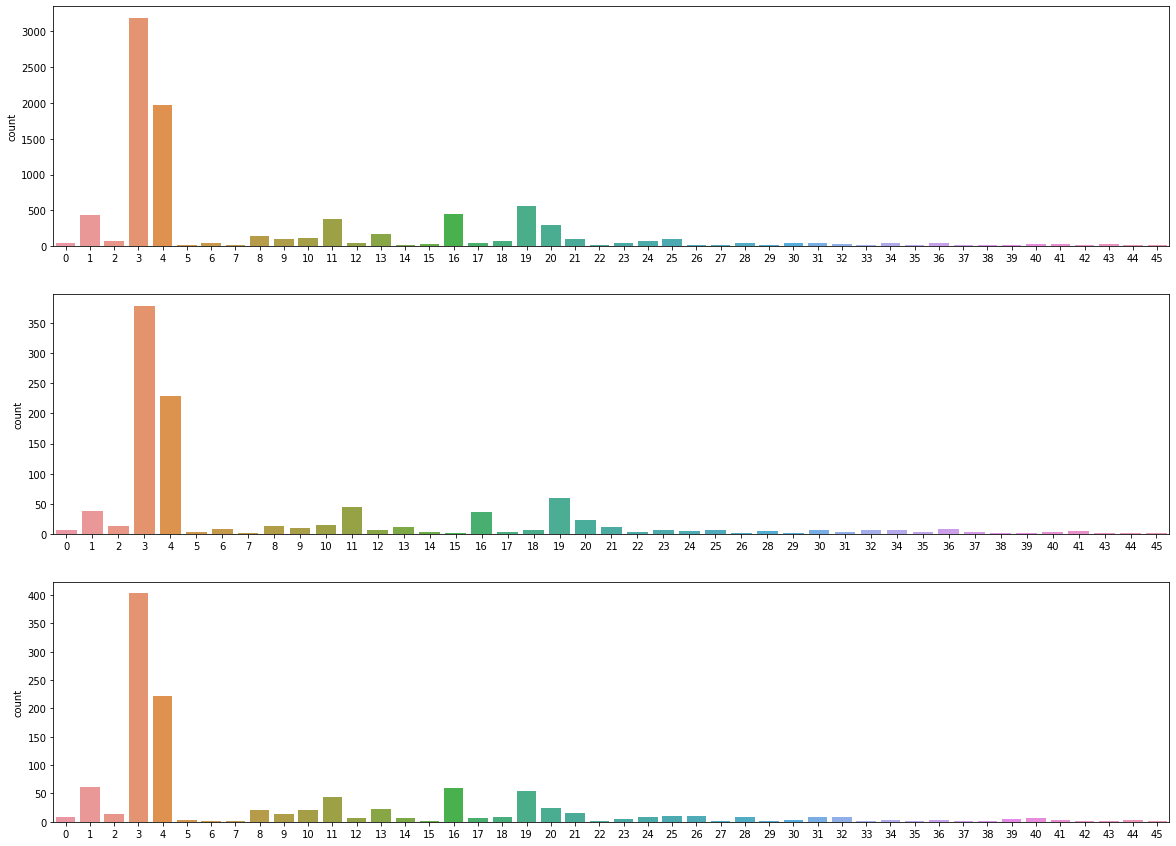

In [109]:
# label distibution on train / dev / test

fig = plt.figure(figsize=(20, 15))
fig.add_subplot(3, 1, 1)
sns.countplot(df_train[1])
fig.add_subplot(3, 1, 2)
sns.countplot(df_dev[1])
fig.add_subplot(3, 1, 3)
sns.countplot(df_test[1])

In [101]:
df_train[1]

array([ 9, 16,  3, ...,  3,  1,  3])

# Pre-processing

In [86]:
padded_train = pad_sequences(df_train[0], padding=PADDING_TYPE, maxlen=MAX_LENGTH)
padded_dev = pad_sequences(df_dev[0], padding=PADDING_TYPE, maxlen=MAX_LENGTH)
label_train = df_train[1]
label_dev = df_dev[1]

print(padded_train.shape, label_train.shape, padded_dev.shape, label_dev.shape)

(9094, 200) (9094,) (1011, 200) (1011,)


# Modeling

In [0]:
def getModel():
    from tensorflow.keras import Sequential, regularizers
    from tensorflow.keras.layers import InputLayer, Lambda, Embedding, Dense, Dropout, Bidirectional, LSTM
    from tensorflow.keras.optimizers import Adam

    regularizer = regularizers.l2(0.001)

    model = Sequential()
    model.add(Embedding(VOCAB_SIZE+1, EMBEDDING_DIM))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(N_LABELS, activation='softmax'))

    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

In [0]:
# Callbacks
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# cb_earlystop = EarlyStopping(patience=10)
# cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=2, 
#                                             verbose=1, 
#                                             factor=0.5, 
#                                             min_lr=0.00001)

# Tensorboards callback setting
# Clear logs prior to logging data.
# !rm -rf logs

# Create log directory
# logdir = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
# cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [94]:
%%time

model = getModel()

# %tensorboard --logdir logs
history = model.fit(x=padded_train, y=label_train
                    , epochs=5, validation_data=(padded_dev, label_dev), verbose=1
                    # , callbacks=[cb_tensorboard]
                    # , callbacks=[cb_earlystop, cb_learning_rate_reduction]
                    )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         128128    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 46)                2990      
Total params: 410,734
Trainable params: 410,734
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
285/285 [==============================] - 7s 26ms/step - loss: 1.9610 - acc: 0.5247 - val_loss: 1.

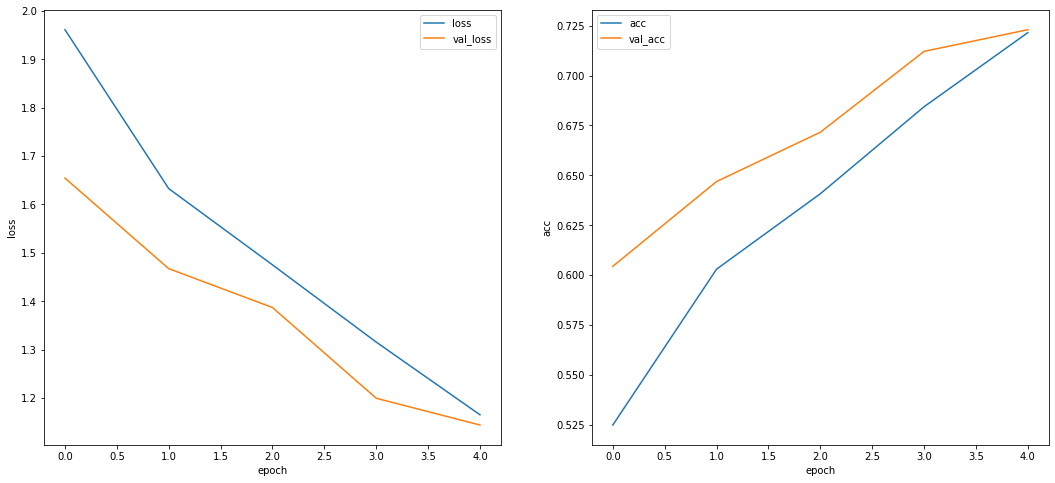

In [95]:
def plot_history(history):
    hist = history.history
    fig = plt.figure(figsize=(18, 8))
    iplot = 0
    for key in ['loss', 'acc']:
        iplot += 1
        fig.add_subplot(1, 2, iplot)
        plt.xlabel('epoch')
        plt.ylabel(key)
        plt.plot(range(len(hist[key])), hist[key], label = key)
        plt.plot(range(len(hist['val_' + key])), hist['val_' + key], label = 'val_' + key)
        plt.legend()
    plt.show()

plot_history(history)

# Model Evaluation

In [96]:
padded_test, label_test = pad_sequences(df_test[0], padding=PADDING_TYPE, maxlen=MAX_LENGTH), df_test[1]

eval = model.evaluate(padded_test, label_test)
print('Test data: Loss = {}, Accuracy = {}'.format(eval[0], eval[1]))
print('Right Prediction: {}, Wrong Prediction: {}'.format(eval[1]*n_test, (1.0-eval[1])*n_test))

36/36 [==============================] - 0s 10ms/step - loss: 1.2793 - acc: 0.7026
Test data: Loss = 1.279341459274292, Accuracy = 0.7025823593139648
Right Prediction: 788.9999895095825, Wrong Prediction: 334.0000104904175


In [97]:
%%time

test_labels = np.array(label_test)
test_pred = model.predict(padded_test).argmax(axis=1)

CPU times: user 839 ms, sys: 32 ms, total: 871 ms
Wall time: 871 ms


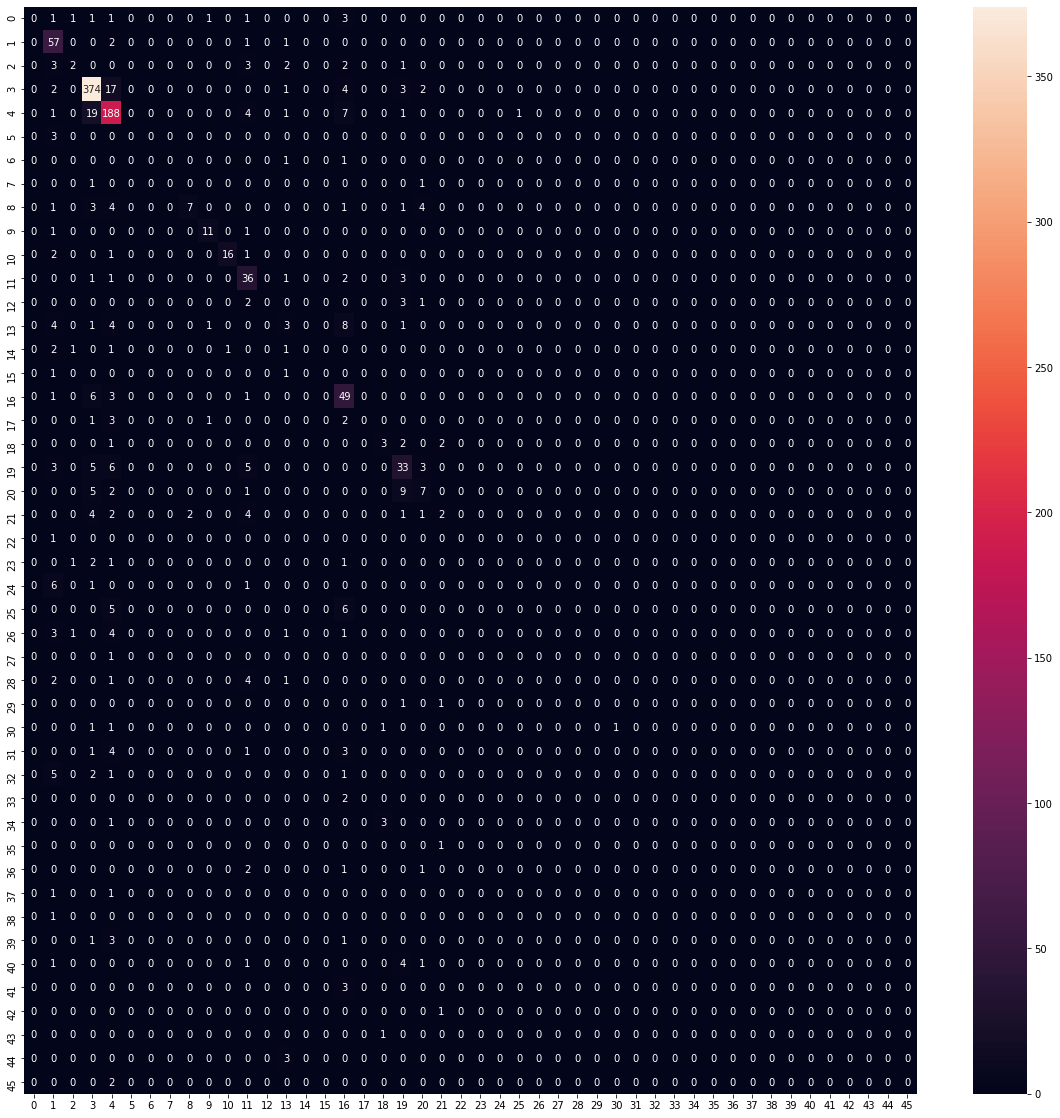

In [99]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
fig = plt.figure(figsize=(20, 20))
sns.heatmap(pd.DataFrame(cm, range(N_LABELS), range(N_LABELS)), annot=True, fmt='d')

In [115]:
itxts = np.where(test_labels!=test_pred)[0]
for i in range(10):
    txt, label = df_test[0][itxts[i]], df_test[1][itxts[i]]
    print('First 20 elements in the sample text:', txt[:20])
    print('The words:', [index_2_words[iword] for iword in txt[:20]])
    print('PREDICT: {}; LABEL: {}'.format(test_pred[itxts[i]], label))

First 20 elements in the sample text: [1, 294, 517, 237, 543, 5, 4, 141, 2, 590, 2, 802, 57, 8, 77, 55, 2, 6, 593, 42]
The words: ['the', 'who', 'sector', 'cut', '38', 'said', 'in', 'there', 'of', 'back', 'of', 'soon', 'bank', 'mln', 'stock', 'or', 'of', 'and', 'currently', 'not']
PREDICT: 1; LABEL: 26
First 20 elements in the sample text: [1, 192, 437, 99, 98, 665, 2, 50, 138, 32, 72, 20, 22, 4, 314, 48, 98, 62, 541, 2]
The words: ['the', 'president', '29', '15', 'rate', 'meet', 'of', 'shr', 'international', 'billion', 'also', 'is', 'its', 'in', 'crude', 'but', 'rate', 'oil', '88', 'of']
PREDICT: 3; LABEL: 0
First 20 elements in the sample text: [1, 4, 2, 450, 9, 2, 56, 2, 10, 103, 2, 2, 2, 7, 967, 137, 2, 281, 48, 4]
The words: ['the', 'in', 'of', 'intervention', '3', 'of', '6', 'of', 'for', 'government', 'of', 'of', 'of', 'a', 'efforts', 'rates', 'of', '28', 'but', 'in']
PREDICT: 4; LABEL: 3
First 20 elements in the sample text: [1, 355, 122, 2, 2, 9, 466, 13, 4, 536, 5, 885, 407, 2